_This notebook is part of the material for the [ML Tutorials](https://github.com/NNPDF/como-2025) session._

# Simple Regression with MLPs

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
import matplotlib.pyplot as plt
import pandas as pd

## Let's select some of the parameters

Here we are fixing some parameters that we will use later. Some of them (like `epochs`, `number_of_layers`, etc... ) are specific for the construction of the neural network, while others (like `number_of_replica` and `xsize`) are related to the datasets we are going to first generate and then fit.   

In [2]:
# Select some parameters
xsize = 200 #number of data to be generated
tr_vl_splitting = 0.75 #training/validation splitting
epochs = 200 #number of epochs 
dev_std_exp = 1.0 #std_dev given by nature
dev_std_estimated = 1.0 #std_dev as estimated by experimentalist 
number_of_layers = 3 #number of layers in the NN
number_of_units = 16 #number of units for each layer 
number_of_replica = 10 #number of replica to be generated 
activation = [activations.gelu, activations.selu, activations.relu, activations.elu] #list of activation function of each layer
ex_rep = 0 #example replica for which we look at results
l_rate = 0.01 #learning rate of the optimizer

## Function of nature that we would like to discover

This function could be whatever function of nature we would like to discover from the data. Since this is used to generate the fake data, we also added a gaussian smearing to simulate noise. 

In [3]:
def f_truth(x):
    return (3*x**3 - x**2 + 5*x - 3)

def func_to_fit(x, dev):
    return np.random.normal(loc = f_truth(x), scale = dev)

### Generation of fake data for both training and validation and for all the replicas

This is the point in which we generate fake data. A few things to note:

- We are already splitting the datasets in training and validation, according to `tr_vl_splitting` fraction defined above
- We generate fake data according to a standard deviation given by "nature" (`dev_std_exp`) but then we create our datasets using another standard deviation (`dev_std_estimated`) which could be different from the one given by nature. This is to simulate the fact that uncertainties obtained from experiments could fail to reproduce the oscillation of the data given by nature.
- We are adopting a replica approach, i.e. we are creating one dataset for each replica. We will fit each of them separately later. This behaviour can be disabled setting `number_of_replica = 1`

In the lower cell we are plotting training data, validation data and the original data (i.e. without the smearing introduced by the experimental standard deviation) for an example replica given by `ex_rep`.

In [4]:
all_data = {}
x_tr_size = int(xsize*tr_vl_splitting) #how many x points in training
x_val_size = xsize - x_tr_size #how many x points in validation
x_exp_data_tr = np.random.rand(x_tr_size) #x_data measured by experimentalist for training
y_exp_data_tr = np.array([func_to_fit(x, dev_std_exp) for x in x_exp_data_tr]) #y_data measured by experimentalist for training
x_exp_data_val = np.random.rand(x_val_size) #x_data measured by experimentalist for validation
y_exp_data_val = np.array([func_to_fit(x, dev_std_exp) for x in x_exp_data_val]) #y_data measured by experimentalist for validation
#generation of the pseudodata
for rep in range(number_of_replica):
    all_data[rep]= {
        'x_tr' : x_exp_data_tr , 
        'x_val' : x_exp_data_val, 
        'y_tr' : np.array([np.random.normal(loc = y_t, scale = dev_std_estimated) for y_t in y_exp_data_tr]), 
        'y_val' : np.array([np.random.normal(loc = y_v, scale = dev_std_estimated) for y_v in y_exp_data_val])}

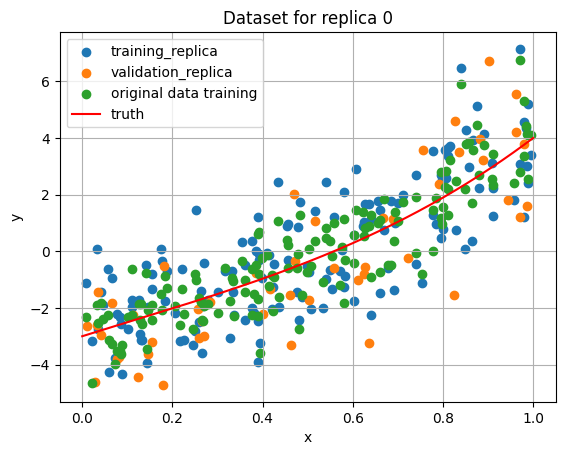

In [5]:
plt.scatter(all_data[ex_rep]['x_tr'],all_data[ex_rep]['y_tr'], label='training_replica')
plt.scatter(all_data[ex_rep]['x_val'],all_data[ex_rep]['y_val'], label='validation_replica')
plt.scatter(x_exp_data_tr, y_exp_data_tr, label="original data training" )
x = np.linspace(0, 1, 1000) #x values for plotting the truth function
plt.plot(x, f_truth(x), label='truth', color='red')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dataset for replica ' + str(ex_rep) )
plt.legend()
plt.show()
plt.close()

## Let's now build the model

It is time to build the model that will fit all the replicas. Since we are going to define several models (one for each replica), let's create a function...

In [6]:
def make_model(number_of_layers, number_of_units_per_layer):
    input_la = keras.Input(shape=(1,)) #input layer
    model = keras.Sequential([input_la])
    for _, acti_func in zip(range(number_of_layers), activation): #inclusion of all the other layers with respective act. function
        model.add(layers.Dense(number_of_units_per_layer, activation=acti_func))
    model.add(layers.Dense(1)) #output layer
    return model

This function constructs a model in **tensoflow** with the number of layer and the number of units for each layer given as input. Moreover, it sets the activation function for each layer as given in `activation`.

Now let's create a model for each replica. In doing so we need to call the function `make_model` and also we need to set a few parameters:

- The *loss_function*, which is the function the algorithm will try to minimize. In this case we choose the `MeanSquaredError` 
- The *optimizer*, which is the algorithm used to minimize the loss function. In this case we are using `SGD`. For this optimizer we also need to set the learning rate, which is a measure of how "aggressive" the optimizer is.

In the cell below we can also see the summary of the model for our example replica.

In [7]:
all_models = {}
#We construct a model for each replica 
for rep in range(number_of_replica):
    model = make_model(number_of_layers, number_of_units)
    loss_mse = keras.losses.MeanSquaredError() #loss function
    opt_SGD = keras.optimizers.SGD(learning_rate = l_rate ) #optimizer
    model.compile(loss=loss_mse, optimizer = opt_SGD)
    all_models[rep] = model

In [8]:
all_models[ex_rep].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593 (2.32 KB)

 Trainable params: 593 (2.32 KB)

 Non-trainable params: 0 (0.00 B)

## Let's train all the models

It is finally time to train all the models to their own replica data. To do that we just need to call the function `fit()` which takes as input

1. The x and y traning data.
2. The number of epochs (i.e. the number of iterations of the optimizer)
3. The x and y validation data

Once we run the training for each replica we get the history of the training and validation losses as output. 

In [9]:
all_histories = {}
for rep in all_models:
    all_histories[rep] = all_models[rep].fit(
        x = all_data[rep]['x_tr'], 
        y = all_data[rep]['y_tr'], 
        batch_size = len(all_data[rep]['x_tr']), 
        epochs = epochs, 
        validation_data = (all_data[rep]['x_val'],all_data[rep]['y_val']))

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 5.6794 - val_loss: 8.5667
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.6432 - val_loss: 8.5322
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.6110 - val_loss: 8.4984
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.5805 - val_loss: 8.4660
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5513 - val_loss: 8.4342
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5232 - val_loss: 8.4027
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.4960 - val_loss: 8.3716
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.4696 - val_loss: 8.3408
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.4439 - val_loss: 8.3102
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.4187 - val_loss: 8.2796
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.3942 - val_loss: 8.2489
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3700 - val_l

### Let's look at the training/valdation losses for an example replica

We can have a look to the loss values as a function of the epoch for our example replica. We can see that after about 200 epochs the values of both the training and validation losses are more or less stable.  

In [10]:
hist = pd.DataFrame(all_histories[ex_rep].history)
hist['epoch'] = all_histories[ex_rep].epoch
hist.tail()

,loss,val_loss,epoch
195,2.067836,2.784555,195
196,2.067782,2.787176,196
197,2.067697,2.785794,197
198,2.067645,2.787085,198
199,2.067621,2.782191,199


In [11]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

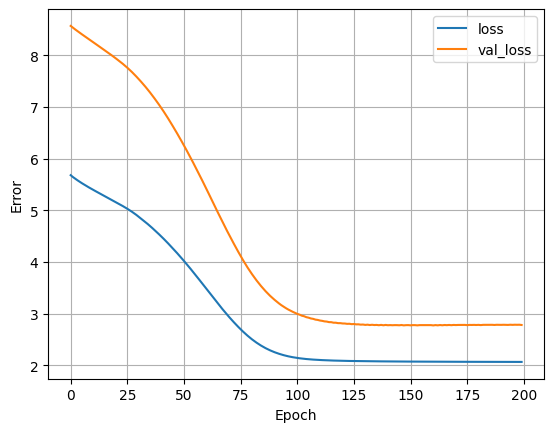

In [12]:
plot_loss(all_histories[ex_rep])

### Now let's look to predictions 

Let's now try to reconstruct the original function asking the models to predict the function over a linear grid in x.  We then plot data, predictions and real function for each replica.

In [13]:
x = tf.linspace(0.0, 1.0, 1000) #simple grid in x
all_y_predicted = {} #predictions for each replica 
for rep in range(number_of_replica):
    y = all_models[rep].predict(x)
    all_y_predicted[rep] = y

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


In [14]:
#this function plots the training and validation data for a certain replica, together with our prediction and real function
def plot_fit(x, y, x_tr_rep, y_tr_rep, x_val_rep, y_val_rep):
    plt.scatter(x_tr_rep, y_tr_rep, label='Training_Data')
    plt.scatter(x_val_rep, y_val_rep, label='Validation_Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.plot(x, f_truth(x), label='Truth', color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

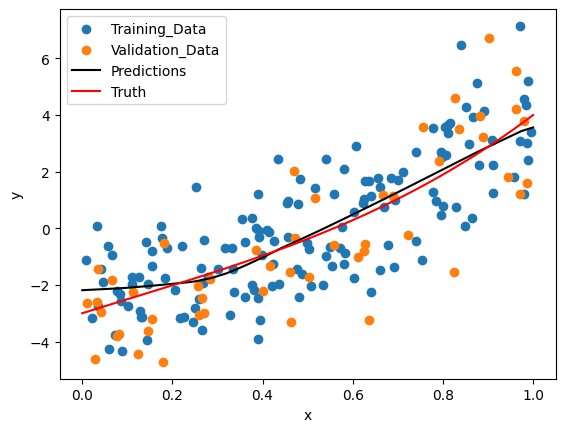

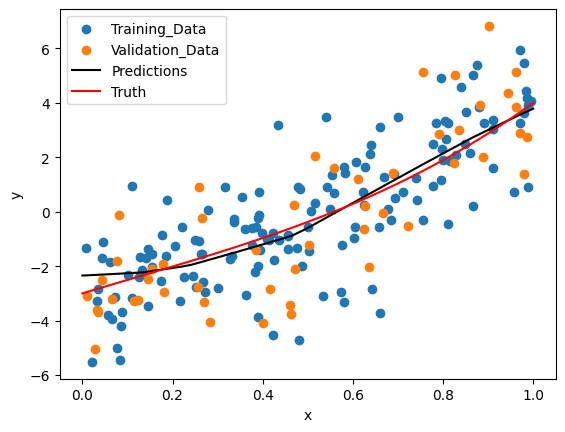

In [15]:
for rep in range(number_of_replica):
    if rep > 1:
        break
    plot_fit(x, all_y_predicted[rep], all_data[rep]['x_tr'], all_data[rep]['y_tr'], all_data[rep]['x_val'], all_data[rep]['y_val'])
    plt.show()
    plt.close()

We can do even something more: we can construct the envelope of the predictions of all our replicas to construct a central prediction (given by the mean over the replicas) and an uncertainty band (given by the standard deviation of the sample). 

In [16]:
# This creates the envelope of the replica producing a central prediction with a std deviation
def compute_central_pred_and_uncert(all_y_predicted):
    average_y = 0.
    std_y = 0.
    for rep in all_y_predicted:
        average_y += all_y_predicted[rep]
    central_y = average_y/len(all_y_predicted)
    for rep in all_y_predicted:
        std_y += (all_y_predicted[rep] - central_y) ** 2
    std_y = np.sqrt(std_y / (len(all_y_predicted) - 1)) if len(all_y_predicted) != 1 else 0.
    return central_y, std_y

In [17]:
all_y_central, all_y_std = compute_central_pred_and_uncert(all_y_predicted)

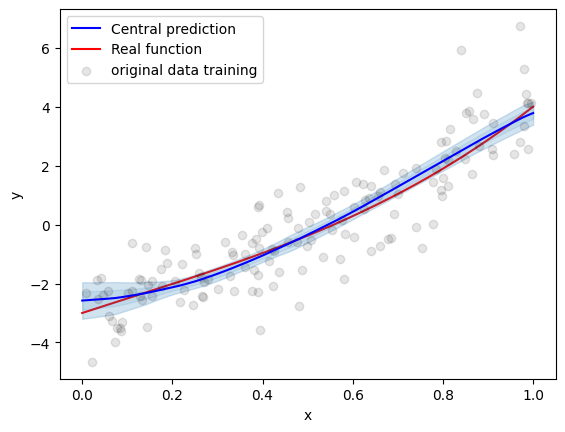

In [18]:
plt.plot(x, all_y_central, color = "blue", label='Central prediction')
for i in range(1,3):
    plt.fill_between(
        x,
        all_y_central[:,0] - i * all_y_std[:,0],
        all_y_central[:,0] + i * all_y_std[:,0],
        alpha=0.1*i,
        color="C0"
    )
plt.plot(x, f_truth(x), label='Real function', color='red', zorder=-1)
plt.scatter(x_exp_data_tr, y_exp_data_tr, label="original data training" , alpha=1/10, color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
plt.close()
